# Bayesian network model of predator-prey interactions

## 1. Description

Here, I build a Bayesian network implementation of the DAG where there is no feedback between the predator and the prey's behavior within a match.

Our objective is to use causal inference to model the predator-prey interaction as it changes throughout the predator's experience. Our DAG explains how we expect the system to work.

## 2. Prepare the session

I start by importing the librairies that I'll need to build the network.

In [1]:
# For Bayesian networks
import bnlearn as bn

# For data manipulations
from pathlib import Path
import pandas as pd
import numpy as np

## 3. Import the data

I import the data to build the network.

In [2]:
# Specify the parent folder
notebook_dir = Path.cwd()
parent_folder = notebook_dir.parent.parent

# Data path
data_subfolder = "data"
file_name = "FraserFranco-etal-XXXX.csv"

# Full path to data file
file_path = parent_folder / data_subfolder / file_name

# Import dataset
dat = pd.read_csv(file_path, index_col = None)

### 3.1 Visualize the data structure

Let's start by checking the data

In [3]:
dat.head()

,match_id,predator_id,xp_level,timestamp,game_mode,realm_id,environment_id,avatar_id,game_duration,prey_avg_rank,...,predicted_mean_speed,predicted_sigma_speed,cluster,hunting_type,chase_count,chase_count_success,attacks_count,prey_avg_heal_count,prey_var_heal_count,chase_success_ratio
0,002W3HHO,pred558338,interm,2021-01-14 22:33:06,Online,The Macmillan Estate,Suffocation Pit,Spirit,523.008972,5.50,...,-0.092314,0.283652,1,ambush-flexible,17,8,17,2.250000,2.916667,0.470588
1,005QEKAB,pred390909,novice,2020-12-30 09:14:30,Online,Backwater Swamp,The Pale Rose,Trapper,802.905701,4.50,...,-0.109873,0.286322,1,ambush-flexible,27,7,17,2.666667,4.333333,0.259259
2,00ATEFT5,pred389952,advanced,2021-04-25 11:57:02,Online,The Macmillan Estate,Suffocation Pit,Oni,693.849854,4.25,...,0.032009,-0.138640,1,intercepting-intermediate,30,6,11,3.750000,10.916667,0.200000
3,00BQMP7T,pred35544,advanced,2021-03-17 03:01:23,Online,Léry's Memorial Institute,Treatment Theatre,Executioner,907.008728,8.50,...,0.024512,-0.061111,1,intercepting-intermediate,20,8,11,2.500000,13.666667,0.400000
4,00CQOXUD,pred199640,novice,2020-12-15 10:42:03,Online,Autohaven Wreckers,Blood Lodge,Hillbilly,605.748718,15.00,...,-0.009210,0.140301,3,intercepting-intermediate,24,6,12,3.500000,20.333333,0.250000


In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               100062 non-null  object 
 1   predator_id            100062 non-null  object 
 2   xp_level               100062 non-null  object 
 3   timestamp              100062 non-null  object 
 4   game_mode              100062 non-null  object 
 5   realm_id               100062 non-null  object 
 6   environment_id         100062 non-null  object 
 7   avatar_id              100062 non-null  object 
 8   game_duration          100062 non-null  float64
 9   prey_avg_rank          100062 non-null  float64
 10  total_xp_pred          100062 non-null  int64  
 11  cumul_xp_pred          100062 non-null  int64  
 12  hunting_success        100062 non-null  int64  
 13  points_predator        100062 non-null  int64  
 14  pred_speed             100062 non-nu

In [5]:
print("Colum names:", dat.columns)

Colum names: Index(['match_id', 'predator_id', 'xp_level', 'timestamp', 'game_mode',
       'realm_id', 'environment_id', 'avatar_id', 'game_duration',
       'prey_avg_rank', 'total_xp_pred', 'cumul_xp_pred', 'hunting_success',
       'points_predator', 'pred_speed', 'prey_avg_speed',
       'predicted_mean_speed', 'predicted_sigma_speed', 'cluster',
       'hunting_type', 'chase_count', 'chase_count_success', 'attacks_count',
       'prey_avg_heal_count', 'prey_var_heal_count', 'chase_success_ratio'],
      dtype='object')


## 4. Build a simple Bayesian network

Here, I use my expertise and knowledge of the system to build the network. In this manuscript, we suggest a causal model of predator-prey interactions, and we thus build our model based on our beliefs on how the system works.

### 4.1 Select variables for the Bayesian network

I start by subsetting the variables that I will use for the model.

In [6]:
# Discretize the continous columns
dat["prey_avg_speed_bin"] = pd.qcut(
    x = dat.prey_avg_speed,
    q = 5
)

# Select relevant variables
selected_variables = [
    "xp_level",
    "hunting_type",
    "hunting_success",
    "prey_avg_speed_bin"
]

# Subset the data
subset = dat[selected_variables]
subset

,xp_level,hunting_type,hunting_success,prey_avg_speed_bin
0,interm,ambush-flexible,4,"(2.153, 2.35]"
1,novice,ambush-flexible,1,"(2.35, 2.506]"
2,advanced,intercepting-intermediate,0,"(2.506, 2.671]"
3,advanced,intercepting-intermediate,4,"(0.619, 2.153]"
4,novice,intercepting-intermediate,2,"(2.506, 2.671]"
...,...,...,...,...
100057,interm,intercepting-intermediate,3,"(0.619, 2.153]"
100058,advanced,cursorial-specialist,1,"(2.671, 3.664]"
100059,interm,intercepting-intermediate,2,"(2.506, 2.671]"
100060,interm,cursorial-specialist,2,"(2.153, 2.35]"


I cannot discretize the continuous variables if I don't drop NaN values.

Here, there is only one NaN for prey_avg_speed, so I can safely remove it.

In [7]:
# Check NaNs
subset[subset.isna().any(axis=1)]

# Drop NaNs
subset = subset.dropna()

### 4.2 Build the Bayesian network structure

Here, I build the relationships (edges) between the variables (nodes).

The model goes like this :

experience --> hunting type --> hunting success

hunting type --> prey speed

prey speed --> hunting success

In [8]:
edges = [
    ("xp_level", "hunting_type"),
    ("hunting_type", "hunting_success"),
    ("hunting_type", "prey_avg_speed_bin"),
    ("prey_avg_speed_bin", "hunting_success")
]

In [9]:
subset.head()

,xp_level,hunting_type,hunting_success,prey_avg_speed_bin
0,interm,ambush-flexible,4,"(2.153, 2.35]"
1,novice,ambush-flexible,1,"(2.35, 2.506]"
2,advanced,intercepting-intermediate,0,"(2.506, 2.671]"
3,advanced,intercepting-intermediate,4,"(0.619, 2.153]"
4,novice,intercepting-intermediate,2,"(2.506, 2.671]"


In [23]:
DAG = bn.make_DAG(edges)

[bnlearn] >bayes DAG created.


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


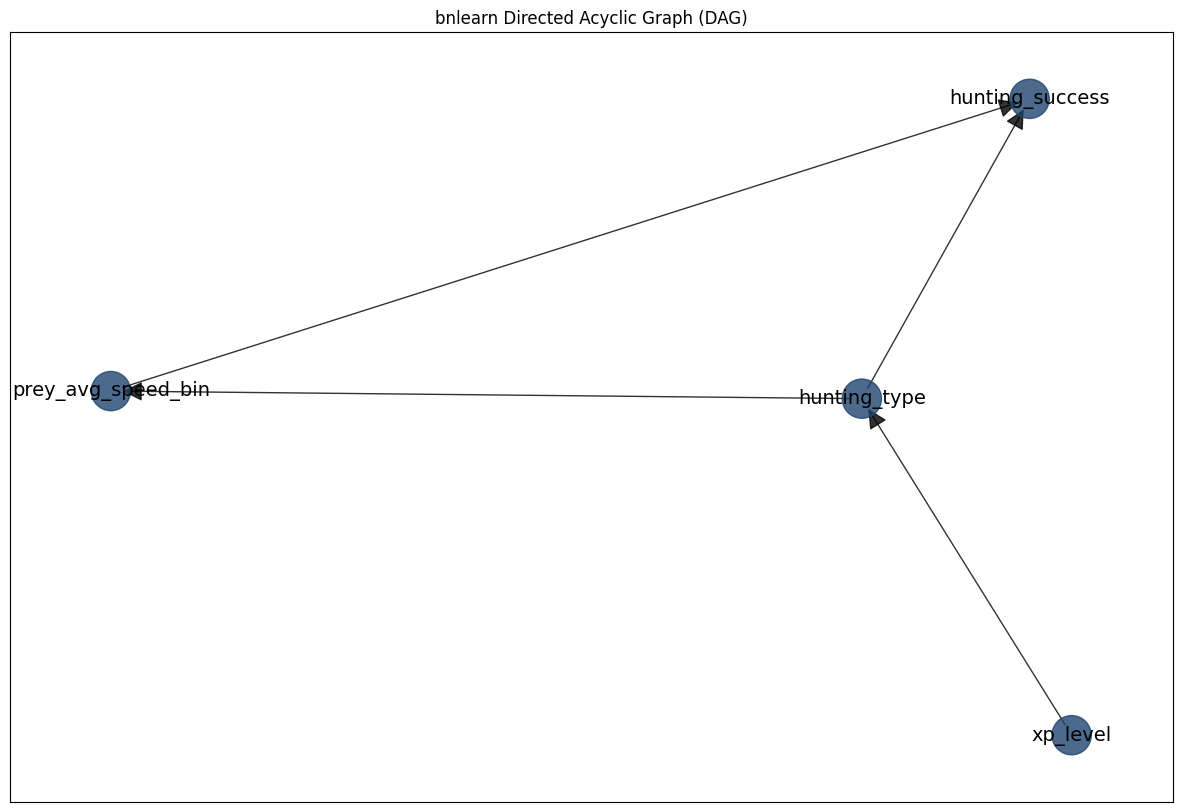

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'xp_level': array([ 0.29541767, -1.        ]),
  'hunting_type': array([0.09097358, 0.02208188]),
  'hunting_success': array([0.25450891, 0.9327764 ]),
  'prey_avg_speed_bin': array([-0.64090015,  0.04514172])},
 'G': <networkx.classes.digraph.DiGraph at 0x7f915330c8b0>,
 'node_properties': {'xp_level': {'node_color': '#1f456e', 'node_size': 800},
  'hunting_type': {'node_color': '#1f456e', 'node_size': 800},
  'hunting_success': {'node_color': '#1f456e', 'node_size': 800},
  'prey_avg_speed_bin': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('xp_level', 'hunting_type'): {'color': '#000000',
   'weight': 1},
  ('hunting_type', 'hunting_success'): {'color': '#000000', 'weight': 1},
  ('hunting_type', 'prey_avg_speed_bin'): {'color': '#000000', 'weight': 1},
  ('prey_avg_speed_bin', 'hunting_success'): {'color': '#000000',
   'weight': 1}}}

In [24]:
bn.plot(DAG)

In [25]:
DAG = bn.parameter_learning.fit(
    DAG, subset,
    methodtype = "bayes"
)

[bnlearn] >Parameter learning> Computing parameters using [bayes]


[bnlearn] >CPD of xp_level:
+--------------------+----------+
| xp_level(advanced) | 0.304295 |
+--------------------+----------+
| xp_level(interm)   | 0.461566 |
+--------------------+----------+
| xp_level(novice)   | 0.234139 |
+--------------------+----------+
[bnlearn] >CPD of hunting_type:
+-----+---------------------+
| ... | xp_level(novice)    |
+-----+---------------------+
| ... | 0.23375171979846074 |
+-----+---------------------+
| ... | 0.40829071989707033 |
+-----+---------------------+
| ... | 0.35795756030446885 |
+-----+---------------------+
[bnlearn] >CPD of hunting_success:
+--------------------+-----+
| hunting_type       | ... |
+--------------------+-----+
| prey_avg_speed_bin | ... |
+--------------------+-----+
| hunting_success(0) | ... |
+--------------------+-----+
| hunting_success(1) | ... |
+--------------------+-----+
| hunting_success(2) | ... |
+--------------------+-----+
| hunting_success(3) | ... |
+--------------------+-----+
| hunting_success(4)

In [29]:
# Convert to onehot
dfhot, dfnum = bn.df2onehot(subset)

# Compute edge strength with the chi_square test statistic
obj = bn.independence_test(
    DAG,
    dfnum,
    test = "chi_square",
    prune = False
)
obj


[df2onehot] >Auto detecting dtypes.


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 4/4 [00:00<00:00, 30.33it/s]


[df2onehot] >Total onehot features: 12
[bnlearn] >Compute edge strength with [chi_square]


{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f9152432e00>,
 'adjmat': target              xp_level  hunting_type  hunting_success  \
 source                                                        
 xp_level               False          True            False   
 hunting_type           False         False             True   
 hunting_success        False         False            False   
 prey_avg_speed_bin     False         False             True   
 
 target              prey_avg_speed_bin  
 source                                  
 xp_level                         False  
 hunting_type                      True  
 hunting_success                  False  
 prey_avg_speed_bin               False  ,
 'config': {'verbose': 3, 'method': 'bayes', 'n_jobs': -1},
 'model_edges': [('xp_level', 'hunting_type'),
  ('hunting_type', 'hunting_success'),
  ('hunting_type', 'prey_avg_speed_bin'),
  ('prey_avg_speed_bin', 'hunting_success')],
 'structure_scores': {'k2': -527800.69484

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


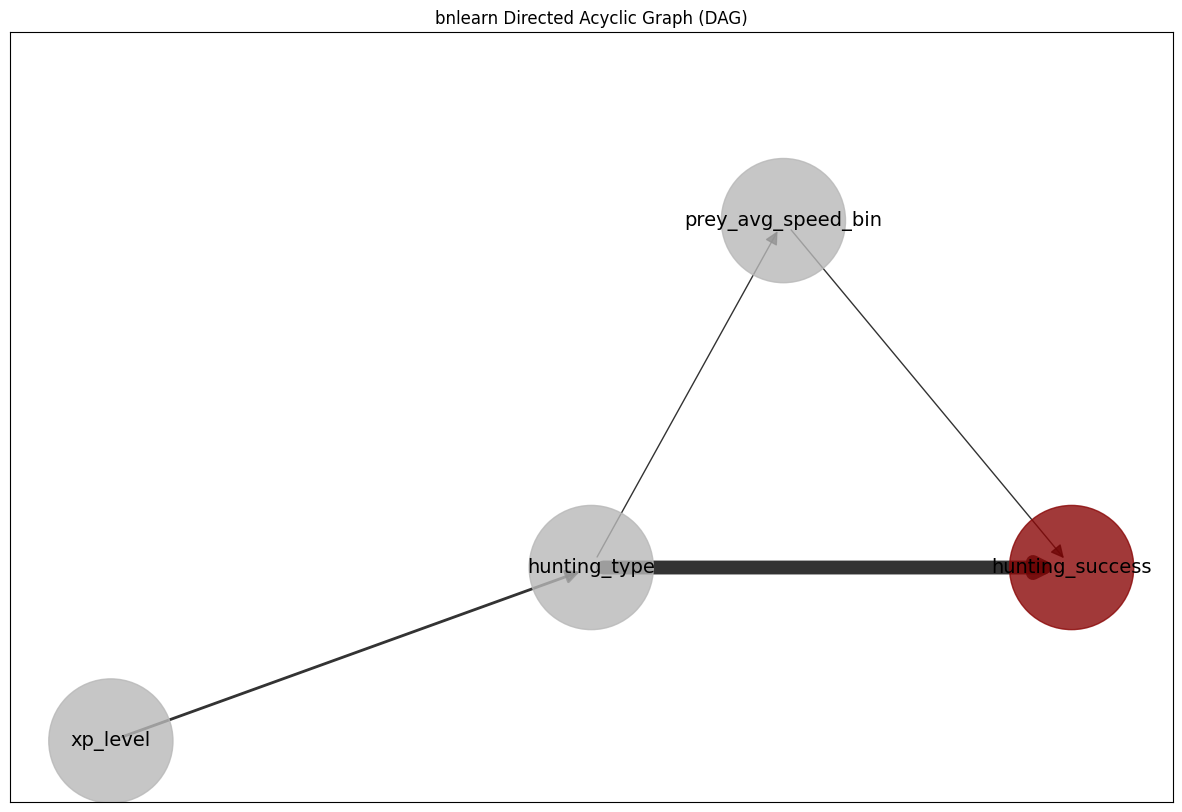

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'xp_level': (0.5, -0.005),
  'hunting_type': (1, 0),
  'hunting_success': (1.5, 0),
  'prey_avg_speed_bin': (1.2, 0.01)},
 'G': <networkx.classes.digraph.DiGraph at 0x7f91534604c0>,
 'node_properties': {'xp_level': {'node_color': '#B8B8B8', 'node_size': 8000},
  'hunting_type': {'node_color': '#B8B8B8', 'node_size': 8000},
  'hunting_success': {'node_color': '#8A0707', 'node_size': 8000},
  'prey_avg_speed_bin': {'node_color': '#B8B8B8', 'node_size': 8000}},
 'edge_properties': {('xp_level', 'hunting_type'): {'color': '#000000',
   'weight': 2.0347040045526716},
  ('hunting_type', 'hunting_success'): {'color': '#000000', 'weight': 10},
  ('hunting_type', 'prey_avg_speed_bin'): {'color': '#000000', 'weight': 1},
  ('prey_avg_speed_bin', 'hunting_success'): {'color': '#000000',
   'weight': 1}}}

In [27]:
# Set node properties
node_properties = bn.get_node_properties(DAG)
edge_properties = bn.get_edge_properties(DAG)

# Set specific color for one node and a different color for the rest
specific_node = "hunting_success"
specific_color = "#8A0707"
default_color = "#B8B8B8"
size_to_set = 8000

for node in node_properties.keys():
    if node == specific_node:
        node_properties[node]["node_color"] = specific_color
    else:
        node_properties[node]["node_color"] = default_color
    node_properties[node]["node_size"] = size_to_set

edge_properties['hunting_type', 'hunting_success']['weight']=10
edge_properties['hunting_type', 'prey_avg_speed_bin']['weight']=1
edge_properties['prey_avg_speed_bin', 'hunting_success']['weight']=1
edge_properties['xp_level', 'hunting_type']['weight']=2.0347040045526716

pos = {
    "xp_level": (0.5, -0.005),
    "hunting_type": (1, 0),
    "hunting_success": (1.5, 0),
    "prey_avg_speed_bin": (1.2, 0.01)
}

params_static = {"arrowstyle":"-|>", "arrowsize":20, "layout":"spring_layout"}

# Plot
bn.plot(
    DAG,
    interactive = False,
    pos = pos,
    node_properties = node_properties,
    edge_properties = edge_properties,
    params_static = params_static
)

# When I apply the chisquare test, it seems like the edge weights aren't computed properly in the plot function. It's like its applying weights to the wrong edges.

In [21]:
edge_properties = bn.get_edge_properties(DAG)
edge_properties

[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.


{('hunting_type', 'hunting_success'): {'color': '#000000', 'weight': 10.0},
 ('hunting_type', 'prey_avg_speed_bin'): {'color': '#000000', 'weight': 1.0},
 ('prey_avg_speed_bin', 'hunting_success'): {'color': '#000000',
  'weight': 1.0},
 ('xp_level', 'hunting_type'): {'color': '#000000',
  'weight': 2.0347040045526716}}

In [115]:
bn.print_CPD(DAG)

[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+------------+----------+
|    | xp_level   |        p |
+====+============+==========+
|  0 | advanced   | 0.304295 |
+----+------------+----------+
|  1 | interm     | 0.461566 |
+----+------------+----------+
|  2 | novice     | 0.234139 |
+----+------------+----------+
CPD of xp_level:
+--------------------+----------+
| xp_level(advanced) | 0.304295 |
+--------------------+----------+
| xp_level(interm)   | 0.461566 |
+--------------------+----------+
| xp_level(novice)   | 0.234139 |
+--------------------+----------+
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+---------------------------+------------+----------+
|    | hunting_type              | xp_level   |        p |
+====+===========================+============+==========+
|  0 | ambush-flexible           | advanced   | 0.237742 |
+----+------------------

{'xp_level':    xp_level         p
 0  advanced  0.304295
 1    interm  0.461566
 2    novice  0.234139,
 'hunting_type':                 hunting_type  xp_level         p
 0            ambush-flexible  advanced  0.237742
 1            ambush-flexible    interm  0.241736
 2            ambush-flexible    novice  0.233752
 3       cursorial-specialist  advanced  0.424557
 4       cursorial-specialist    interm  0.427796
 5       cursorial-specialist    novice  0.408291
 6  intercepting-intermediate  advanced  0.337702
 7  intercepting-intermediate    interm  0.330468
 8  intercepting-intermediate    novice  0.357958,
 'hunting_success':     hunting_success               hunting_type prey_avg_speed_bin         p
 0                 0            ambush-flexible     (0.619, 2.153]  0.217304
 1                 0            ambush-flexible      (2.153, 2.35]  0.232185
 2                 0            ambush-flexible      (2.35, 2.506]  0.245145
 3                 0            ambush-flexible    

In [19]:
DAG

{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f9047805480>,
 'adjmat': target              xp_level  hunting_type  hunting_success  \
 source                                                        
 xp_level               False          True            False   
 hunting_type           False         False             True   
 hunting_success        False         False            False   
 prey_avg_speed_bin     False         False             True   
 
 target              prey_avg_speed_bin  
 source                                  
 xp_level                         False  
 hunting_type                      True  
 hunting_success                  False  
 prey_avg_speed_bin               False  ,
 'config': {'verbose': 3, 'method': 'bayes', 'n_jobs': -1},
 'model_edges': [('xp_level', 'hunting_type'),
  ('hunting_type', 'hunting_success'),
  ('hunting_type', 'prey_avg_speed_bin'),
  ('prey_avg_speed_bin', 'hunting_success')],
 'structure_scores': {'k2': -527800.69484